Basics:
- Submit for access with email here: https://courses.spatialthoughts.com/end-to-end-gee.html#working-with-image-collections

- Set up GCP project 'w210-oil=spill-detection' and enable the Google Earth Engine API. See pricing details.

- Follow these instructions: https://github.com/ageller/EarthEngineToGeoTIFF/blob/main/downloadChicagoMap.ipynb


In [20]:
#install necessary packages, need to do this just once.
import sys
!{sys.executable} -m pip install earthengine-api rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Mount your google drive in google colab, to import function from tutorial.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

# tutorial script
from EarthEngineToGeoTIFF import getSentinalS2SRImage

Mounted at /content/drive


ModuleNotFoundError: ignored

In [17]:
import ee
import rasterio
from rasterio.plot import show as showRasterio

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=_d94t5qpsU2qaDBY2Qxc-cvxt89gt3qCkJVggY72cTA&tc=z6GIT3uTtVQpQOju0Q9yo9SOGr9qBs_CvcffvEzV5rQ&cc=dUxasXiJY_Eor5L3fpFa-Y2HDBjHwETETWNNod2gkas

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJq2p9feOeFKeaayrfAMUYW5fCMNe1lq-ZNtbCs6aOtn7_kr4TUmvuI

Successfully saved authorization token.


In [19]:
# Chicago central latitude, longitude and approximate size
lat = 41.8781
lon = -87.6298
sze = 0.65
_ = getSentinalS2SRImage(lon, lat, sze, 'ChicagoGeoTIFF-test.tif')

NameError: ignored

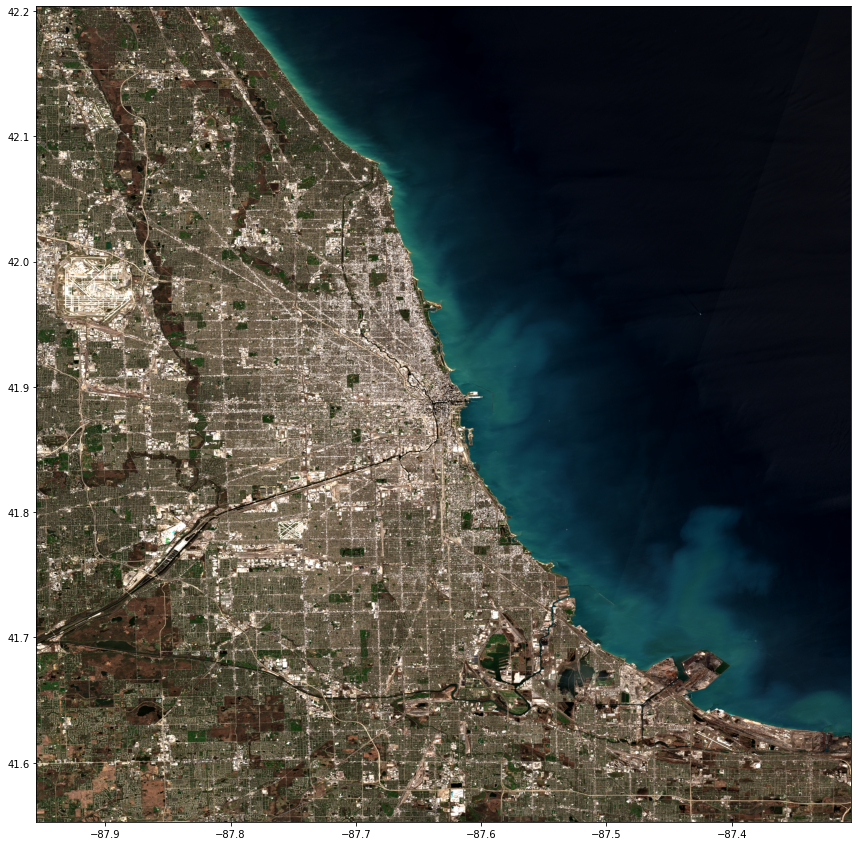

In [ ]:
f,ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('ChicagoGeoTIFF-test.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('Chicago-test.png', bbox_inches='tight')

chicago.close()

So able to get the tutorial to work, above is an RBG image of Chicago per tutorial.

Below is a function to download from both S2 and S1 satellites and output an array of all the bands of the listed satellites and a list of corresponding band labels (to use for eventual data set selection).

Note: Function will return an error if S2 is not in the list of satellites.

In [ ]:
# Code to download images from multiple satellites.

import zipfile
import os
import requests

import numpy as np

import ee
import rasterio

def getSentinalS2_S1Image(lon, lat, sze, filename, dateMin = '2020-04-01', dateMax = '2020-04-30', vmin = 0, vmax = 3500, satellites = ['S2','S1']):
    '''    
    download image from the Sentinal S2 and S1 satellites, at the given coordinates
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze : size of the edge of the box in degrees
    dateMin : minimum date to use for image search in year-month-day (e.g., 2020-08-01)
    dateMax : maximum date to use for image search in year-month-day (e.g., 2020-08-31)
    vMin : minimum value to select in the Sentinal image pixels (I think this should be close to 0)
    vMax : maximum value to select in the Sentinal image pixels (I think this should be close to 3000)
    filename : output filename for the GeoTIFF image
    
    Note: it's possible that the vMin and vMax values should be different for each band to make the image look nicer
    
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD
    '''


    print('Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... ')
    
    # define the area of interest, using the Earth Engines geometry object
    coords = [
         [lon - sze/2., lat - sze/2.],
         [lon + sze/2., lat - sze/2.],
         [lon + sze/2., lat + sze/2.],
         [lon - sze/2., lat + sze/2.],
         [lon - sze/2., lat - sze/2.]
    ]
    aoi = ee.Geometry.Polygon(coords)
    if 'S2' in satellites:
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .sort('CLOUDY_PIXEL_PERCENTAGE')\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # define the S2 bands to download.
      bands = ['B4','B3','B2','B1','B5','B6','B7','B8','B8A','B9','B11','B12']

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=30,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': 30,
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()
          
      # create a combined RGB geotiff image, https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
      print('Creating 3-band GeoTIFF image ... ')
      
      # Define which bands are to be displayed.
      B2 = rasterio.open('B2.tif')
      B3 = rasterio.open('B3.tif')
      B4 = rasterio.open('B4.tif')
      x, y = B4.read(1).shape # this is for final np.array.

      # get the scaling
      image = np.array([B2.read(1), B3.read(1), B4.read(1)]).transpose(1,2,0)
      p2, p98 = np.percentile(image, (2,98))

      # use the B2 image as a starting point so that I keep the same parameters
      B2_geo = B2.profile
      B2_geo.update({'count': 3})

      with rasterio.open(filename, 'w', **B2_geo) as dest:
          dest.write( (np.clip(B4.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
          dest.write( (np.clip(B3.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
          dest.write( (np.clip(B2.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

      B2.close()
      B3.close()
      B4.close()
      
      # update here to output np.array, https://rasterio.readthedocs.io/en/latest/topics/reading.html
      img_spectra = np.zeros((x,y))
      for band in bands:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))

      # remove the intermediate files
      for selection in bands:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')


    if 'S1' in satellites:
      print('Downloading Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling... ')
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # See paper, only need these two bands.
      # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#bands
      bands_S1 = ['VV','VH']

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands_S1:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=30,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': 30,
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()

      # Open relevant images.
      VV = rasterio.open('VV.tif')
      VH = rasterio.open('VH.tif')
      x,y = VH.read(1).shape # this is for final np.array.
      
      # create relevant numpy array.
      for band in bands_S1:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))
        bands.append(band)

      # remove the intermediate files
      for selection in bands_S1:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')
      

    return bands, img_spectra[:,:,1:] # remove the first dimension of zeros.

In [ ]:
# Test cell for download function.

# Chicago central latitude, longitude and approximate size.
lat = 41.8781
lon = -87.6298
sze = 0.1 # for Sentienl-1, have found an upper limit to the file size allowed to download.
bands, img = getSentinalS2_S1Image(lon, lat, sze, 'ChicagoGeoTIFF-edited.tif', dateMin='2020-01-06', dateMax='2020-02-10')

# print output details.
print('bands:',bands)
print('img shape:',img.shape)

Creating 3-band GeoTIFF image ... 
bands: ['B4', 'B3', 'B2', 'B1', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'VV', 'VH']
img shape: (372, 373, 14)


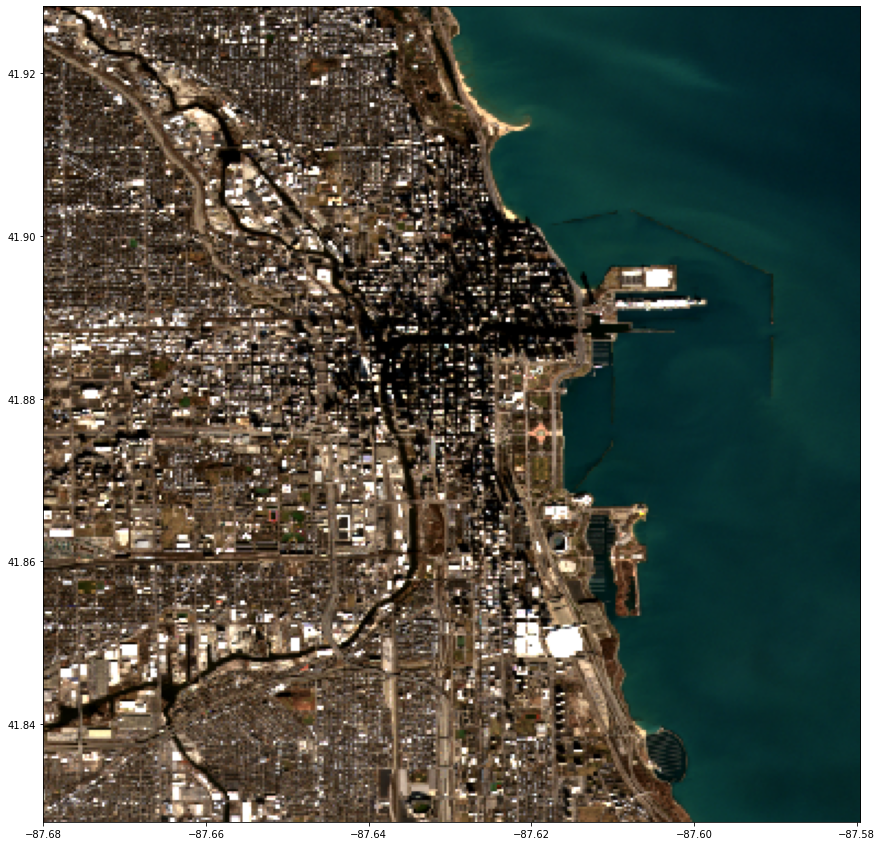

In [ ]:
f,ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('ChicagoGeoTIFF-edited.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('Chicago-edited.png', bbox_inches='tight')

chicago.close()